# Set up

In [1]:
import pandas as pd 
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import plotly.express as px

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Import Data

In [2]:
df_accidents = pd.read_csv("../../data/bike_car_ped_accidents_2021.csv")
gdf_bikelanes = gpd.read_file("../../data/bike_lanes_Berlin.geojson")

In [3]:
gdf_accidents = gpd.GeoDataFrame(df_accidents, geometry=gpd.points_from_xy(df_accidents.LongitudeWGS84, df_accidents.LatitudeWGS84))
gdf_accidents.crs = "EPSG:4326"
gdf_accidents_bikes = gdf_accidents[gdf_accidents["InvolvingBike"]==1]

In [4]:
gdf_bikelanes.head()

,gml_id,subject_code,segment,segment_district,station_street,storage_name,location,lane_type,length_in_m,use_mandatory,geometry
0,b_radverkehrsanlagen.1,10-000415,58530025_58530021.01,B1/B5,Alt-Kaulsdorf,Marzahn-Hellersdorf,Kaulsdorf,bike path,26.0,yes,"MULTILINESTRING ((13.58199 52.50505, 13.58237 ..."
1,b_radverkehrsanlagen.2,10-000039,60530006_60530009.01,B1/B5,Alt-Mahlsdorf,Marzahn-Hellersdorf,Mahlsdorf,bike path,16.0,yes,"MULTILINESTRING ((13.60630 52.50471, 13.60639 ..."
2,b_radverkehrsanlagen.3,10-000038,60530005_60530006.01,B1/B5,Alt-Mahlsdorf,Marzahn-Hellersdorf,Mahlsdorf,bike path,510.0,no,"MULTILINESTRING ((13.59882 52.50483, 13.59905 ..."
3,b_radverkehrsanlagen.4,10-000011,57530025_57530026.01,B1/B5,Alt-Biesdorf,Marzahn-Hellersdorf,Biesdorf,bike path,76.0,yes,"MULTILINESTRING ((13.56179 52.50846, 13.56214 ..."
4,b_radverkehrsanlagen.5,10-000012,57530001_57530017.01,B1/B5,Alt-Biesdorf,Marzahn-Hellersdorf,Biesdorf,bike path,192.0,yes,"MULTILINESTRING ((13.56277 52.50814, 13.56333 ..."


In [5]:
gdf_accidents_bikes.head()

,ObjectID,vehicle_types,State,District,LOR_ab_2021,AccidentYear,AccidentMonth,AccidentHour,DayOfWeek,AccidentCategory,...,InvolvingBike,InvolvingCar,InvolvingPedestrian,RoadCondition,GraphicCoord1,GraphicCoord2,LongitudeWGS84,LatitudeWGS84,accident_outcome,geometry
5,112180,bike,11,2,2200208.0,2021,8,10,3,2,...,1,0,0,0,797898.6687,5825137.375,13.389006,52.494841,1,POINT (13.38901 52.49484)
7,112182,bike + car,11,9,9100101.0,2021,9,19,4,3,...,1,1,0,1,802664.0378,5825207.751,13.459050,52.492850,0,POINT (13.45905 52.49285)
8,112184,bike + car,11,10,10400940.0,2021,7,20,6,3,...,1,1,0,0,812566.7795,5827181.034,13.606291,52.504953,0,POINT (13.60629 52.50495)
15,112212,bike,11,2,2500727.0,2021,8,15,4,3,...,1,0,0,0,802141.8982,5827763.741,13.453702,52.516049,0,POINT (13.45370 52.51605)
19,112223,bike + car,11,9,9100203.0,2021,9,6,4,3,...,1,1,0,0,804105.6497,5824365.983,13.479450,52.484505,0,POINT (13.47945 52.48450)


# Visualise Bike Accident Locations 

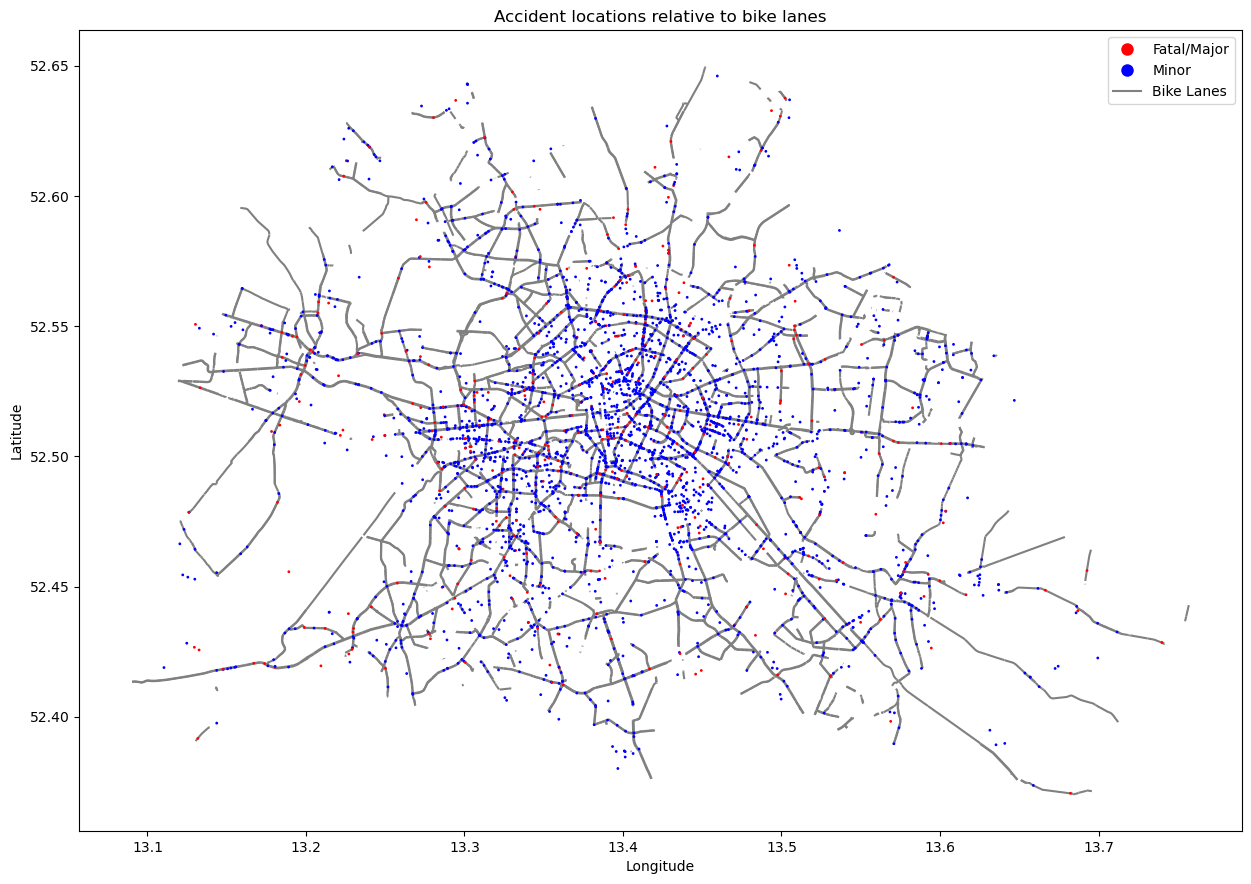

In [9]:
fig, ax = plt.subplots(figsize=(15, 15))

colour_map = {1: 'red', 0: 'blue'}
colours = [colour_map[val] for val in gdf_accidents_bikes["accident_outcome"]]

gdf_accidents_bikes.plot(ax=ax, c=colours, markersize=1, zorder=2)
gdf_bikelanes.plot(ax=ax, color='grey', zorder=1)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label='Fatal/Major', markerfacecolor='red', markersize=10),
                  plt.Line2D([0], [0], marker='o', color='w', label='Minor', markerfacecolor='blue', markersize=10),
                  plt.Line2D([0], [0], color='grey', label='Bike Lanes')]

plt.title('Accident locations relative to bike lanes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(handles=legend_handles, loc="upper right")

plt.show()

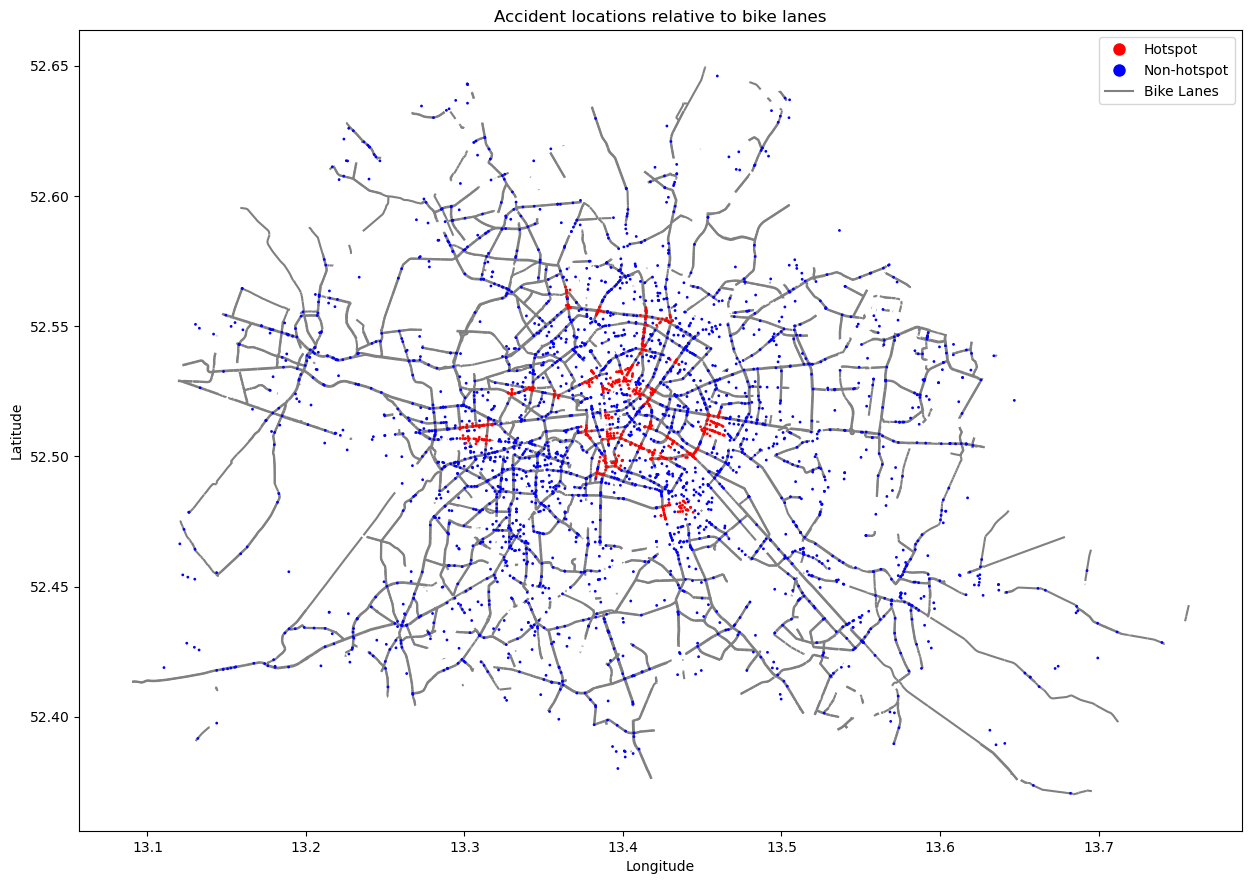

In [7]:
# Extract the coordinates from the GeoDataFrame
coords = gdf_accidents_bikes[['LatitudeWGS84', 'LongitudeWGS84']].values
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.04, min_samples=10).fit(coords_scaled)

# Create a new GeoDataFrame with the cluster labels
gdf_clusters = gdf_accidents_bikes.copy()
gdf_clusters['cluster'] = dbscan.labels_
gdf_clusters["dense"] = gdf_clusters["cluster"].apply(lambda x: 1 if x != -1 else 0) 

# Plot the clusters
fig, ax = plt.subplots(figsize=(15, 15))

colour_map = {1: 'red', 0: 'blue'}
colours = [colour_map[val] for val in gdf_clusters["dense"]]

gdf_clusters.plot(ax=ax, c=colours, markersize=1, zorder=2)
gdf_bikelanes.plot(ax=ax, color='grey', zorder=1)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label='Hotspot', markerfacecolor='red', markersize=10),
                  plt.Line2D([0], [0], marker='o', color='w', label='Non-hotspot', markerfacecolor='blue', markersize=10),
                  plt.Line2D([0], [0], color='grey', label='Bike Lanes')]

plt.title('Accident locations relative to bike lanes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(handles=legend_handles, loc="upper right")

#plt.axhline(52.533, color="g")
#plt.axhline(52.517, color="g")
#plt.axvline(13.41, color="g")
#plt.axvline(13.43, color="g")

#plt.axhline(52.54, color="g")
#plt.axhline(52.5, color="g")
#plt.axvline(13.4, color="g")
#plt.axvline(13.44, color="g")

plt.show()

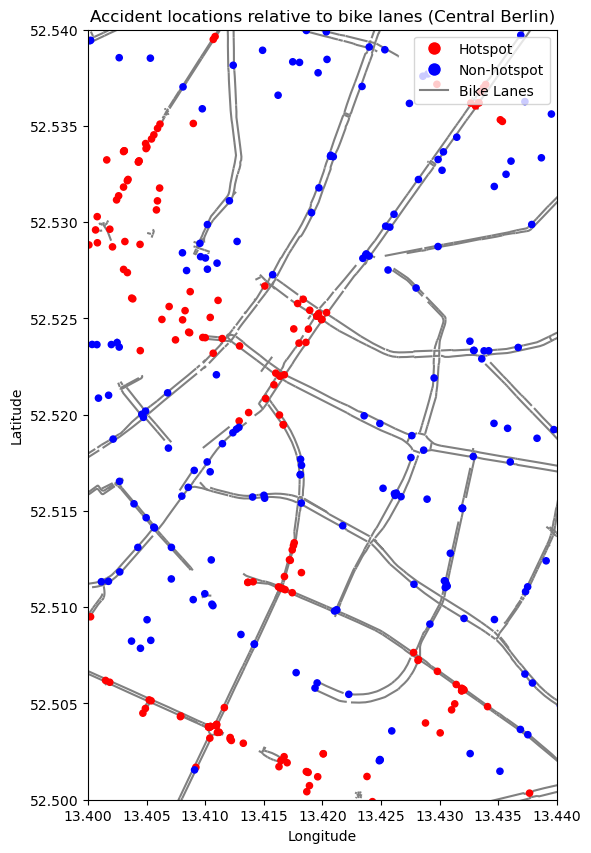

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

colour_map = {1: 'red', 0: 'blue'}
colours = [colour_map[val] for val in gdf_clusters["dense"]]

gdf_clusters.plot(ax=ax, c=colours, markersize=20, zorder=2)
gdf_bikelanes.plot(ax=ax, color='grey', zorder=1)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label='Hotspot', markerfacecolor='red', markersize=10),
                  plt.Line2D([0], [0], marker='o', color='w', label='Non-hotspot', markerfacecolor='blue', markersize=10),
                  plt.Line2D([0], [0], color='grey', label='Bike Lanes')]

plt.title('Accident locations relative to bike lanes (Central Berlin)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(handles=legend_handles, loc="upper right")

plt.xlim(13.4, 13.44)
plt.ylim(52.5, 52.54)

plt.show()